# ISIC (DSLR) Classifier Training

To train our model on the ISIC DSLR dataset, we used the **Adam optimizer** with the following settings:  
- Learning rate: 1e-4  
- Weight decay: 1e-5  
- Dropout probability: 0.5  

We trained the model for **10 epochs** with the **ConvNeXt backbone unfrozen**, selecting the **best model based on validation set performance**.


In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from util import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm

In [4]:
def split_image_paths(image_dir, valid_exts={'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}):
    """
    Splits images into train/val/test lists of (path, class_label),
    including only valid image files.

    Args:
        image_dir (str): root directory with class subfolders
        valid_exts (set): allowed image file extensions (lowercase)

    Returns:
        dict: {'train': [...], 'val': [...], 'test': [...]}
    """
    from sklearn.model_selection import train_test_split

    splits = {'train': [], 'val': [], 'test': []}
    for cls in os.listdir(image_dir):
        class_path = os.path.join(image_dir, cls)
        if not os.path.isdir(class_path):
            continue

        # Filter only valid image files
        files = [
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f)) and
               os.path.splitext(f)[1].lower() in valid_exts
        ]

        # Make full paths with class label
        data = [(os.path.join(cls, f), cls) for f in files]

        # Split: 70% train, 15% val, 15% test
        train_val, test = train_test_split(data, test_size=0.15, random_state=42)
        train, val = train_test_split(train_val, test_size=0.1765, random_state=42)  # ~0.15/0.85

        splits['train'].extend(train)
        splits['val'].extend(val)
        splits['test'].extend(test)

    return splits


In [5]:
splits = split_image_paths("/home/ubuntu/isic-clinical-closeup")

In [6]:
def splits_to_dfs(splits):
    """
    Converts splits dict with lists of (path, class_label)
    into DataFrames with columns 'clinical_path' and 'label'.

    Args:
        splits (dict): {
            'train': [(path, class), ...],
            'val': [...],
            'test': [...],
        }

    Returns:
        dict: {
            'train': pd.DataFrame,
            'val': pd.DataFrame,
            'test': pd.DataFrame,
        }
    """
    # First, get all unique classes to assign numeric labels
    all_classes = set()
    for split in splits.values():
        all_classes.update([cls for _, cls in split])
    class_to_idx = {cls: idx for idx, cls in enumerate(sorted(all_classes))}

    dfs = {}
    for split_name, data in splits.items():
        paths = [p for p, c in data]
        labels = [class_to_idx[c] for _, c in data]
        df = pd.DataFrame({
            "clinical_path": paths,
            "label": labels
        })
        dfs[split_name] = df.reset_index(drop=True)

    return dfs, class_to_idx


In [7]:
dfs, class_to_idx = splits_to_dfs(splits)

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [10]:
image_directory = "/home/ubuntu/isic-clinical-closeup"

In [11]:
train_dataset = ClinicalSquareCropDataset(dfs['train'], image_directory, transform=train_transform)
val_dataset = ClinicalSquareCropDataset(dfs['val'], image_directory, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = ClinicalSquareCropDataset(dfs['test'], image_directory, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
class SimpleMLP(nn.Module):
    """
    Simple MLP model for clinical images only.
    Uses ResNet18 backbone to generate embeddings
    and passes them to an MLP for classification.
    """
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # CNN backbone (ResNet18)
        convnext = models.convnext_tiny(pretrained=True)
        convnext.classifier = nn.Identity()
        self.backbone = convnext
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        # resnet.fc = nn.Identity()  # Remove classifier head
        # self.backbone = resnet
        
        # MLP on top of clinical embeddings
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)  # Binary classification
        )

    def forward(self, clinical):
        x = self.backbone(clinical)  # (B, 512)
        x = self.global_pool(x)           # [B, 768, 1, 1]
        x = x.view(x.size(0), -1)         # [B, 768]
        return self.classifier(x).squeeze(1)  # (B,)


In [15]:
dropout = 0.5
model = SimpleMLP(dropout_rate=dropout).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# --- Training Function ---
def train_one_epoch(loader):
    model.train()
    for batch in loader:
        clinical = batch["clinical"].to(device)
        labels = batch["label"].float().to(device)

        logits = model(clinical)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item():.4f}")

# --- Evaluation Function ---
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_logits, all_labels = [], []

    for batch in loader:
        clinical = batch["clinical"].to(device)
        labels = batch["label"].float().to(device)

        logits = model(clinical)
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    probs = torch.sigmoid(all_logits)
    preds = (probs > 0.5).int()

    accuracy = accuracy_score(all_labels, preds)
    try:
        roc_auc = roc_auc_score(all_labels, probs)
    except:
        roc_auc = float("nan")  # Handle single-class case

    try:
        precision = precision_score(all_labels, preds, zero_division=0)
        recall = recall_score(all_labels, preds, zero_division=0)
    except:
        precision = float("nan")
        recall = float("nan")

    loss = F.binary_cross_entropy(probs, all_labels)
    
    return {
        "loss": loss.item(),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc
    }


In [15]:
# Training loop
best_accuracy = 0

for epoch in range(10):
    print(f"\nEpoch {epoch + 1}")

    train_one_epoch(train_loader)

    train_metrics = evaluate(model, train_loader)
    print(
        f"Train Metrics: Loss = {train_metrics['loss']:.4f}, "
        f"Accuracy = {train_metrics['accuracy']:.4f}, "
        f"Precision = {train_metrics['precision']:.4f}, "
        f"Recall = {train_metrics['recall']:.4f}, "
        f"ROC-AUC = {train_metrics['roc_auc']:.4f}"
    )
    
    metrics = evaluate(model, val_loader)
    print(
        f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
        f"Accuracy = {metrics['accuracy']:.4f}, "
        f"Precision = {metrics['precision']:.4f}, "
        f"Recall = {metrics['recall']:.4f}, "
        f"ROC-AUC = {metrics['roc_auc']:.4f}"
    )
    
    torch.save(model.state_dict(), f"pt_ckpts/isic_model_normalization_epochs_{epoch}.pt")


Epoch 1
Loss: 0.6985
Loss: 0.6785
Loss: 0.6867
Loss: 0.6713
Loss: 0.6768
Loss: 0.6362
Loss: 0.6330
Loss: 0.6149
Loss: 0.6014
Loss: 0.5479
Loss: 0.4801
Loss: 0.4745
Loss: 0.4727
Loss: 0.4241
Loss: 0.3203
Loss: 0.3335
Loss: 0.2937
Loss: 0.3889
Loss: 0.3676
Loss: 0.1222
Loss: 0.2376
Loss: 0.2689
Loss: 0.1480
Loss: 0.2559
Loss: 0.2248
Loss: 0.0898
Loss: 0.4937
Loss: 0.1171
Loss: 0.3694
Loss: 0.3731
Loss: 0.3174
Loss: 0.2673
Loss: 0.1471
Loss: 0.2134
Loss: 0.3661
Loss: 0.2195
Loss: 0.2694
Loss: 0.3298
Loss: 0.1693
Loss: 0.2657
Loss: 0.1925
Loss: 0.3881
Loss: 0.3046
Loss: 0.2671
Loss: 0.4912
Loss: 0.2346
Loss: 0.1794
Loss: 0.1310
Loss: 0.4071
Loss: 0.2424
Loss: 0.3858
Loss: 0.1568
Loss: 0.2313
Loss: 0.2742
Loss: 0.1929
Loss: 0.1324
Loss: 0.2311
Loss: 0.2299
Loss: 0.1744
Loss: 0.2051
Loss: 0.3949
Loss: 0.1907
Loss: 0.1386
Train Metrics: Loss = 0.1451, Accuracy = 0.9452, Precision = 0.9164, Recall = 0.9504, ROC-AUC = 0.9884
Validation Metrics: Loss = 0.1421, Accuracy = 0.9465, Precision = 0.9

In [15]:
model = SimpleMLP(dropout_rate=0)
state_dict = torch.load("pt_ckpts/model_isic_accuracy_epoch_1.pt", map_location=device)
model.load_state_dict(state_dict)
model.to(device)

metrics = evaluate(model, test_loader)
print(f"FINAL MODEL METRICS (TEST)")
print(
    f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
    f"Accuracy = {metrics['accuracy']:.4f}, "
    f"Precision = {metrics['precision']:.4f}, "
    f"Recall = {metrics['recall']:.4f}, "
    f"ROC-AUC = {metrics['roc_auc']:.4f}"
)

FINAL MODEL METRICS (TEST)
Validation Metrics: Loss = 0.2601, Accuracy = 0.9116, Precision = 0.8571, Recall = 0.9364, ROC-AUC = 0.9676


In [16]:
@torch.no_grad()
def evaluate_with_preds(model, loader):
    model.eval()
    all_logits, all_labels = [], []
    all_images = []

    for batch in loader:
        clinical = batch["clinical"].to(device)
        labels = batch["label"].float().to(device)

        logits = model(clinical)

        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
        all_images.extend(clinical.cpu())  # Save images for visualization

    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    probs = torch.sigmoid(all_logits).squeeze()
    preds = (probs > 0.5).int()

    accuracy = accuracy_score(all_labels, preds)
    try:
        roc_auc = roc_auc_score(all_labels, probs)
    except:
        roc_auc = float("nan")

    try:
        precision = precision_score(all_labels, preds, zero_division=0)
        recall = recall_score(all_labels, preds, zero_division=0)
    except:
        precision = float("nan")
        recall = float("nan")

    loss = F.binary_cross_entropy(probs, all_labels)

    return {
        "loss": loss.item(),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "preds": preds.tolist(),
        "labels": all_labels.int().tolist(),
        "images": all_images,  # List of image tensors
        "probs": probs.tolist()
    }



def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

def show_predictions(results, max_images=25, class_names=("Benign", "Malignant")):
    preds = results["preds"]
    labels = results["labels"]
    images = results["images"]
    probs = results["probs"]

    n = min(len(images), max_images)
    cols = 5
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for i in range(n):
        img = images[i]
        pred = preds[i]
        label = labels[i]
        prob = probs[i]

        # Proper de-normalization
        img = denormalize(img).clamp(0, 1)
        img = TF.to_pil_image(img)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

        correct = pred == label
        color = "green" if correct else "red"
        title = f"Pred: {class_names[pred]} ({prob:.2f})\nTrue: {class_names[label]}"
        plt.title(title, color=color, fontsize=10)

    plt.tight_layout()
    plt.show()


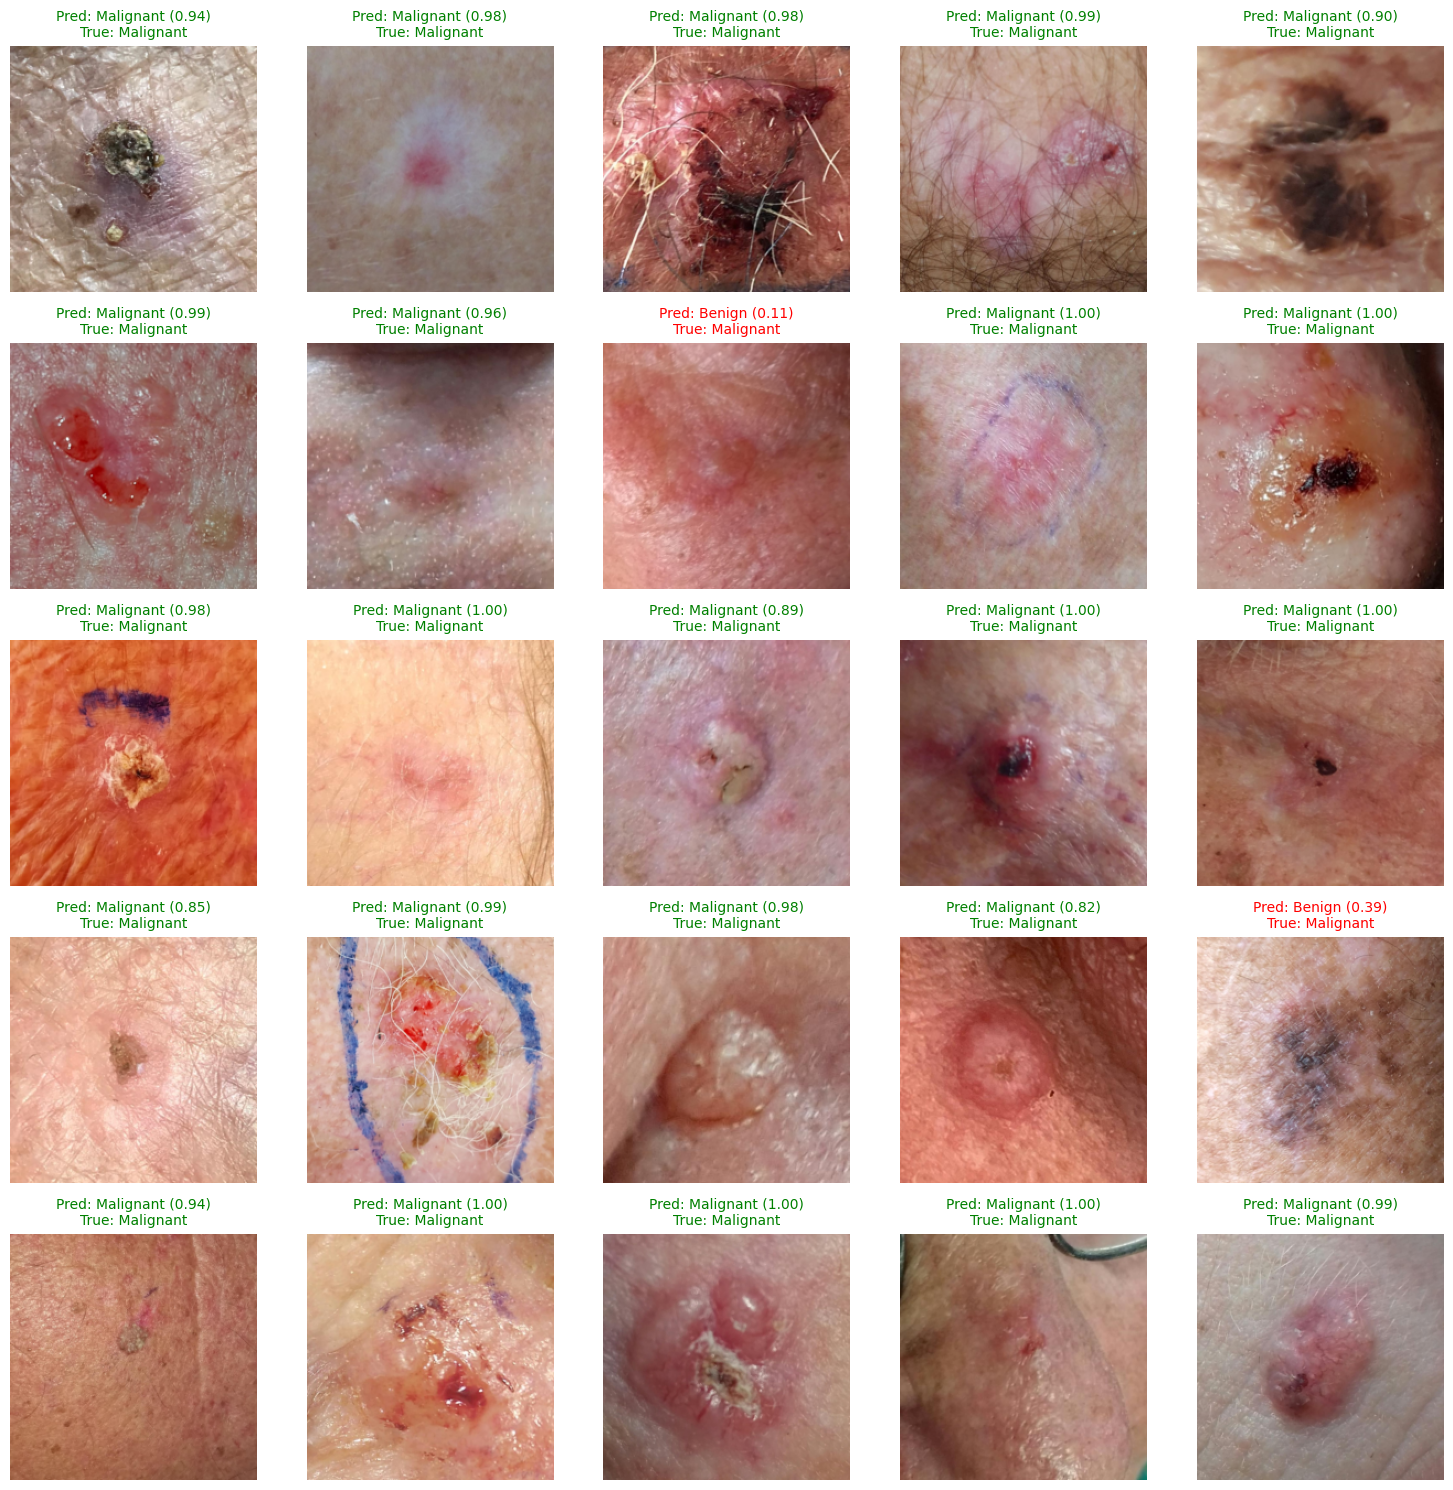

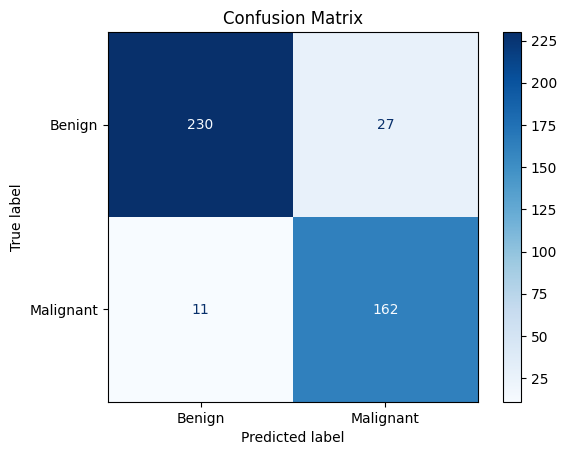

In [17]:
results = evaluate_with_preds(model, test_loader)
show_predictions(results)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(preds, labels, class_names=("Benign", "Malignant")):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(results["preds"], results["labels"])

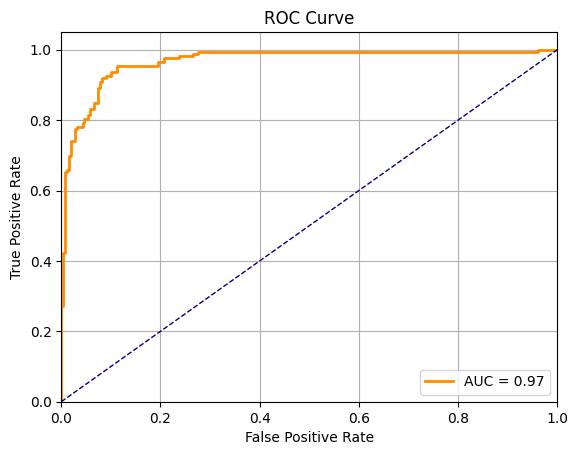

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_auc_curve(probs, labels):
    fpr, tpr, thresholds = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_auc_curve(results["probs"], results["labels"])
